# CAPSULE NETWORKS

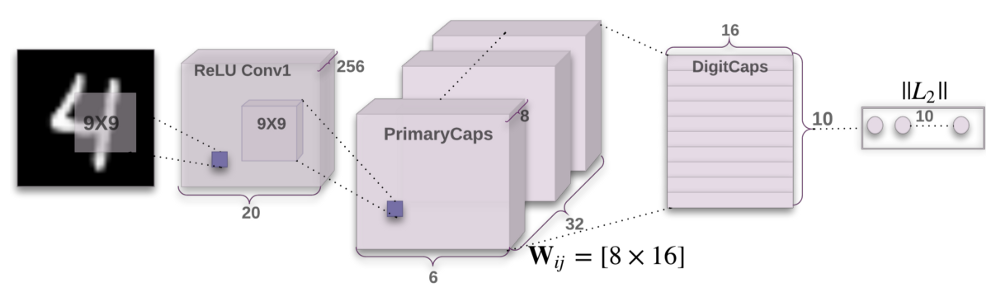

In [ ]:
#Image Credits---->   https://pechyonkin.me/capsules-4/(The best article on capsule network you will see on internet)

In [3]:
"""
Keras implementation of CapsNet in Hinton's paper Dynamic Routing Between Capsules.
"""

import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from utils import combine_images
from PIL import Image
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

K.set_image_data_format('channels_last')


def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))


def train(model, data, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger(args.save_dir + '/log.csv')
    tb = callbacks.TensorBoard(log_dir=args.save_dir + '/tensorboard-logs',
                               batch_size=args.batch_size, histogram_freq=int(args.debug))
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights-{epoch:02d}.h5', monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * (args.lr_decay ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args.lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args.lam_recon],
                  metrics={'capsnet': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay])
    """

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, args.batch_size, args.shift_fraction),
                        steps_per_epoch=int(y_train.shape[0] / args.batch_size),
                        epochs=args.epochs,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, tb, checkpoint, lr_decay])
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights(args.save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)

    from utils import plot_log
    plot_log(args.save_dir + '/log.csv', show=True)

    return model


def test(model, data, args):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=100)
    print('-'*30 + 'Begin: test' + '-'*30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
    print()
    print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
    plt.show()


def load_mnist():
    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    return (x_train, y_train), (x_test, y_test)
    
    # load data
    (x_train, y_train), (x_test, y_test) = load_mnist()

    # define model
    model, eval_model, manipulate_model = CapsNet(input_shape=x_train.shape[1:],
                                                  n_class=len(np.unique(np.argmax(y_train, 1))),
                                                  routings=args.routings)
    model.summary()

    # train or test
    if args.weights is not None:  # init the model weights with provided one
        model.load_weights(args.weights)
    if not args.testing:
        train(model=model, data=((x_train, y_train), (x_test, y_test)), args=args)
    else:  # as long as weights are given, will run testing
        if args.weights is None:
            print('No weights are provided. Will test using random initialized weights.')
        manipulate_latent(manipulate_model, (x_test, y_test), args)
        test(model=eval_model, data=(x_test, y_test), args=args)


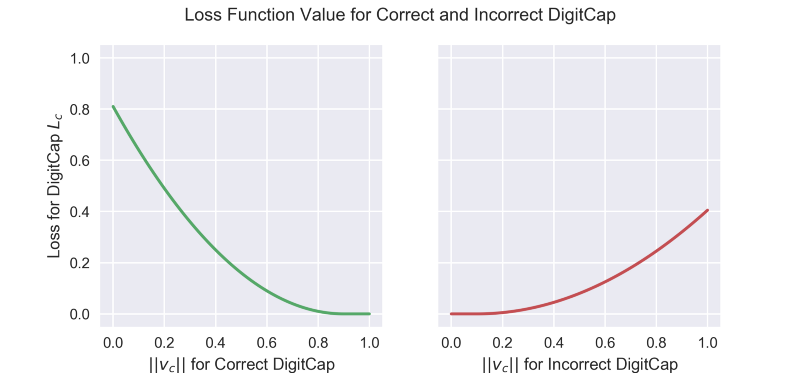